# Reconstrucción de la Curva de Tipos de Interés

Este notebook implementa la reconstrucción de la curva de tipos de interés (ETTI) usando bonos del Tesoro de Estados Unidos mediante:

1. **Bootstrapping** para obtener tasas spot a partir de precios de mercado
2. **Modelo Nelson-Siegel** para ajustar una curva suave a los datos observados

## Metodología

El proceso consta de dos etapas principales:
- **Bootstrapping**: Construcción de la curva spot a partir de bonos zero-coupon y bonos con cupón, procesando los instrumentos ordenados por vencimiento
- **Calibración Nelson-Siegel**: Ajuste de una curva paramétrica usando diferentes métodos de optimización (OLS, Levenberg-Marquardt, Optimización Restringida)


In [209]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


## 1. Carga de Datos

Cargamos el archivo Excel con las cotizaciones de bonos del Tesoro de Estados Unidos.


In [210]:
file_path = "GovernmentBondPrices_UnitedStates.xlsx"
df = pd.read_excel(file_path)


## 2. Normalización de Columnas

Renombramos las columnas para facilitar el procesamiento.


In [211]:
df = df.rename(columns={
    "Cpn": "Coupon_rate",
    "Mat Date": "Maturity_Date",
    "Date": "Valuation_Date"
})


## 3. Conversión de Precios US (Formato 32nds)

En esta celda definimos la función para convertir precios del formato US (puntos y treintaidosavos) a formato decimal. Los bonos con cupón del Tesoro de Estados Unidos cotizan en este formato especial. 

**Ejemplos:**
- `99*19` = 99 + 19/32 = 99.59375
- `98*28¾` = 98 + 28.75/32 = 98.8984

**Fórmula:** $P_{decimal} = P_{entero} + \frac{P_{32avos} + P_{fracción}}{32}$

La función maneja también fracciones Unicode (¼, ½, ¾, etc.) y valores numéricos directos.


In [212]:
UNICODE_FRACTIONS = {
    '¼': 0.25, '½': 0.5, '¾': 0.75,
    '⅛': 0.125, '⅜': 0.375,
    '⅝': 0.625, '⅞': 0.875
}

def us_price_to_decimal(price):
    if isinstance(price, (int, float)):
        return float(price)
    try:
        main, frac = price.split('*')
        integer = float(main)
        match = re.match(r"(\d+)(.*)", frac)
        thirty = int(match.group(1))
        remainder = match.group(2)
        extra = UNICODE_FRACTIONS.get(remainder, 0.0)
        return integer + (thirty + extra) / 32
    except:
        return np.nan


## 4. Normalización de Cupones

En esta celda normalizamos las tasas de cupón para que todas estén en formato porcentaje (0-100). La función detecta si el valor está en decimal (≤ 1) y lo convierte a porcentaje multiplicando por 100. También maneja valores nulos (los convierte a 0 para bonos zero-coupon) y elimina símbolos de porcentaje si están presentes.


In [213]:
def normalize_coupon(c):
    if pd.isna(c):
        return 0.0
    if isinstance(c, str):
        c = c.replace('%', '').strip()
    c = float(c)
    return c * 100 if c <= 1 else c

df["Coupon_rate"] = df["Coupon_rate"].apply(normalize_coupon)


## 5. Detección del Tipo de Cotización

Los datos pueden estar cotizados en **precio** o en **yield**. Detectamos el tipo:
- Si contiene `*`, es precio en formato 32nds
- Si el valor numérico < 30, probablemente es yield (%)
- Si el valor ≥ 30, probablemente es precio


In [214]:
def detect_quote_type(x):
    if isinstance(x, str) and '*' in x:
        return "Price"
    try:
        val = float(x)
        return "Yield" if val < 30 else "Price"
    except:
        return np.nan

df["Bid_type"] = df["Bid"].apply(detect_quote_type)
df["Ask_type"] = df["Ask"].apply(detect_quote_type)

df["Quote_type"] = np.where(
    (df["Bid_type"] == "Yield") | (df["Ask_type"] == "Yield"),
    "Yield",
    "Price"
)

df.loc[df["Quote_type"] == "Price", "Quoted_value"] = (
    df.loc[df["Quote_type"] == "Price", ["Bid", "Ask"]]
      .map(us_price_to_decimal)
      .mean(axis=1)
)

df.loc[df["Quote_type"] == "Yield", "Quoted_value"] = (
    df.loc[df["Quote_type"] == "Yield", ["Bid", "Ask"]]
      .astype(float)
      .mean(axis=1)
)


## 6. Cálculo del Tiempo hasta Vencimiento

En esta celda calculamos el tiempo hasta vencimiento en años usando días exactos entre la fecha de valoración y la fecha de vencimiento. Usamos 365.25 días por año para tener en cuenta los años bisiestos. Filtramos los instrumentos con vencimiento negativo o cero (datos inválidos).


In [215]:
df["Maturity_Date"] = pd.to_datetime(df["Maturity_Date"])
df["Valuation_Date"] = pd.to_datetime(df["Valuation_Date"])
df["T"] = (df["Maturity_Date"] - df["Valuation_Date"]).dt.days / 365.25
df = df[df["T"] > 0]


## 7. Clasificación de Instrumentos y Preparación para Bootstrapping

En esta celda clasificamos los instrumentos en dos categorías:
- **Zero**: Bonos zero-coupon (cupón = 0%)
- **Coupon**: Bonos con cupón (cupón > 0%)

Esta clasificación es fundamental porque el proceso de bootstrapping difiere según el tipo de instrumento. También creamos un DataFrame limpio con solo las columnas necesarias, ordenado por vencimiento (de menor a mayor), y mostramos estadísticas diagnósticas sobre los datos.


In [216]:
df["Instrument_class"] = np.where(df["Coupon_rate"] == 0, "Zero", "Coupon")

clean_df = df[[
    "RIC", "Coupon_rate", "Quoted_value",
    "Quote_type", "T", "Instrument_class"
]].dropna().sort_values("T").reset_index(drop=True)

print("\n" + "="*60)
print("DIAGNÓSTICO DE DATOS")
print("="*60)
print(f"\nTotal de instrumentos después de limpieza: {len(clean_df)}")
print(f"\nPor tipo de instrumento:")
print(clean_df["Instrument_class"].value_counts())
print(f"\nPor tipo de cotización:")
print(clean_df["Quote_type"].value_counts())
print(f"\nBonos con cupón por tipo de cotización:")
if len(clean_df[clean_df["Instrument_class"] == "Coupon"]) > 0:
    print(clean_df[clean_df["Instrument_class"] == "Coupon"]["Quote_type"].value_counts())
print(f"\nRango de vencimientos: {clean_df['T'].min():.2f} - {clean_df['T'].max():.2f} años")
print("="*60 + "\n")



DIAGNÓSTICO DE DATOS

Total de instrumentos después de limpieza: 27

Por tipo de instrumento:
Instrument_class
Zero      20
Coupon     7
Name: count, dtype: int64

Por tipo de cotización:
Quote_type
Yield    20
Price     7
Name: count, dtype: int64

Bonos con cupón por tipo de cotización:
Quote_type
Price    7
Name: count, dtype: int64

Rango de vencimientos: 0.08 - 29.93 años



## 8. Bootstrapping de la Curva Spot

En esta celda implementamos el algoritmo de bootstrapping que construye la curva de tasas spot a partir de los precios de mercado. El proceso se realiza iterativamente, procesando los bonos ordenados por vencimiento:

**Para bonos Zero-Coupon:**
- Si cotiza en yield: $r(T) = YTM/100$
- Si cotiza en precio: $r(T) = -\ln(P/100)/T$

**Para bonos con Cupón:**
- Si cotiza en yield: Usamos YTM como proxy del spot rate
- Si cotiza en precio: Aplicamos bootstrapping iterativo usando spots interpolados de vencimientos anteriores

Guardamos todos los spots generados (no solo uno por vencimiento) para usar todos los puntos en la calibración Nelson-Siegel.


In [217]:
spot_curve_list = []
spot_curve_dict = {}

def interp_spot(t):
    if not spot_curve_dict:
        return 0.0
    Ts = np.array(sorted(spot_curve_dict.keys()))
    rs = np.array([spot_curve_dict[x] for x in Ts])
    if t <= Ts[0]:
        return rs[0]
    if t >= Ts[-1]:
        return rs[-1]
    return np.interp(t, Ts, rs)

for _, row in clean_df.iterrows():
    T = row["T"]
    P = row["Quoted_value"]
    cpn = row["Coupon_rate"]

    if row["Instrument_class"] == "Zero":
        if row["Quote_type"] == "Yield":
            r = P / 100
        else:
            r = -np.log(P / 100) / T
        spot_curve_list.append((T, r, "Zero"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r) / 2
        else:
            spot_curve_dict[T] = r
        continue

    face = 100
    freq = 2
    c = face * cpn / 100 / freq
    n = int(np.round(T * freq))
    
    if row["Quote_type"] == "Yield":
        r_T = P / 100
        spot_curve_list.append((T, r_T, "Coupon"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r_T) / 2
        else:
            spot_curve_dict[T] = r_T
        continue
    
    pv_known = 0.0
    for k in range(1, n):
        t = k / freq
        if t < T:
            r_t = interp_spot(t)
            pv_known += c * np.exp(-r_t * t)
    
    pv_final = P - pv_known
    
    if pv_final > 0 and pv_final < (face + c) * 2:
        r_T = -np.log(pv_final / (face + c)) / T
        spot_curve_list.append((T, r_T, "Coupon"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r_T) / 2
        else:
            spot_curve_dict[T] = r_T


## 9. Creación del DataFrame de Spots

En esta celda creamos un DataFrame con todos los spots generados durante el bootstrapping. Este DataFrame contiene todos los puntos observados (no solo uno por vencimiento), lo cual es importante para la calibración del modelo Nelson-Siegel ya que permite usar toda la información disponible. Mostramos estadísticas sobre los spots generados: total, únicos por vencimiento, y rangos de vencimientos y tasas.


In [218]:
boot_df = pd.DataFrame(spot_curve_list, columns=["T", "Spot", "Instrument_type"]).sort_values("T")

print("\n" + "="*60)
print("RESULTADOS DEL BOOTSTRAPPING")
print("="*60)
print(f"\nTotal de spots generados: {len(boot_df)}")
print(f"\nSpots únicos por T: {boot_df['T'].nunique()}")
print(f"\nRango de vencimientos con spots: {boot_df['T'].min():.2f} - {boot_df['T'].max():.2f} años")
print(f"\nRango de spot rates: {boot_df['Spot'].min()*100:.4f}% - {boot_df['Spot'].max()*100:.4f}%")
print("="*60 + "\n")



RESULTADOS DEL BOOTSTRAPPING

Total de spots generados: 27

Spots únicos por T: 22

Rango de vencimientos con spots: 0.08 - 29.93 años

Rango de spot rates: 3.4450% - 5.1498%



## 10. Calibración del Modelo Nelson-Siegel (Método OLS)

En esta celda implementamos el método OLS con grid search para calibrar el modelo Nelson-Siegel. El modelo parametriza la curva mediante: $y(\tau) = \beta_0 + \beta_1 \cdot f_1(\tau) + \beta_2 \cdot f_2(\tau)$.

**Proceso:**
1. Definimos funciones para calcular $f_1(\tau)$ y $f_2(\tau)$ del modelo Nelson-Siegel
2. Realizamos grid search sobre $\lambda$ en el rango [0.1, 5.0] con 100 puntos
3. Para cada $\lambda$, construimos la matriz de diseño y estimamos $\beta$ mediante OLS
4. Seleccionamos el $\lambda$ que minimiza el SSE (suma de errores al cuadrado)

Este método transforma el problema no lineal en una secuencia de problemas lineales, garantizando robustez y estabilidad.


In [219]:
def ns_functions(tau, lam):
    ratio = tau / lam
    f1 = np.where(ratio < 1e-10, 1.0, (1 - np.exp(-ratio)) / ratio)
    f2 = f1 - np.exp(-ratio)
    return f1, f2

def nelson_siegel_curve(tau, beta0, beta1, beta2, lam):
    f1, f2 = ns_functions(tau, lam)
    return beta0 + beta1 * f1 + beta2 * f2

tau_obs = boot_df["T"].values
y_obs = boot_df["Spot"].values

lambda_grid = np.linspace(0.1, 5.0, 100)
best_sse = np.inf
best_params = None
best_lam = None

for lam in lambda_grid:
    f1, f2 = ns_functions(tau_obs, lam)
    X = np.column_stack([np.ones_like(tau_obs), f1, f2])
    betas, residuals, rank, s = np.linalg.lstsq(X, y_obs, rcond=None)
    y_fit = X @ betas
    sse = np.sum((y_obs - y_fit)**2)
    
    if sse < best_sse:
        best_sse = sse
        best_params = betas
        best_lam = lam

beta0_ols, beta1_ols, beta2_ols = best_params
y_fit_ols = nelson_siegel_curve(tau_obs, beta0_ols, beta1_ols, beta2_ols, best_lam)
sse_ols = np.sum((y_obs - y_fit_ols)**2)


## 11. Visualización de la Curva OLS

En esta celda visualizamos los resultados del método OLS: mostramos los spots observados (diferenciando bonos zero-coupon en azul y bonos con cupón en verde claro) junto con la curva Nelson-Siegel ajustada en rojo. Esto nos permite verificar visualmente la calidad del ajuste.


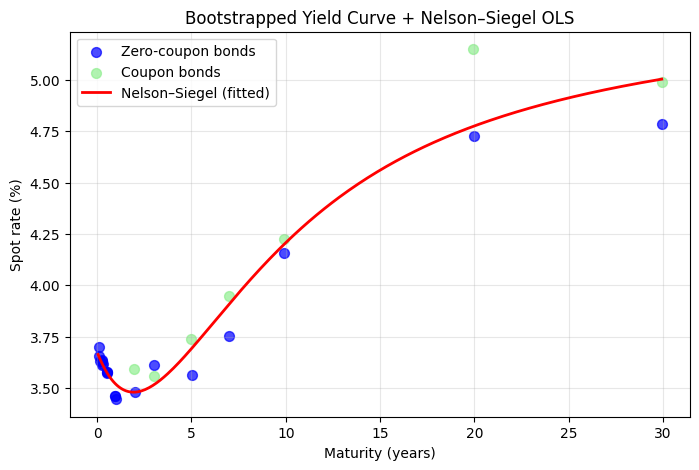

In [220]:
T_grid = np.linspace(0.05, boot_df["T"].max(), 300)
curve = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)

plt.figure(figsize=(8,5))

zero_bonds = boot_df[boot_df["Instrument_type"] == "Zero"]
coupon_bonds = boot_df[boot_df["Instrument_type"] == "Coupon"]

if len(zero_bonds) > 0:
    plt.scatter(zero_bonds["T"], 100 * zero_bonds["Spot"], 
                color='blue', label="Zero-coupon bonds", alpha=0.7, s=50)

if len(coupon_bonds) > 0:
    plt.scatter(coupon_bonds["T"], 100 * coupon_bonds["Spot"], 
                color='lightgreen', label="Coupon bonds", alpha=0.7, s=50)

plt.plot(T_grid, 100 * curve, label="Nelson–Siegel (fitted)", linewidth=2, color='red')

plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Bootstrapped Yield Curve + Nelson–Siegel OLS")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 12. Resultados del Método OLS

En esta celda mostramos los parámetros estimados del modelo Nelson-Siegel usando el método OLS con grid search: $\beta_0$ (level), $\beta_1$ (slope), $\beta_2$ (curvature), $\lambda$ (decay factor) y el error de ajuste (SSE).


In [221]:
print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)
print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")
print("="*50 + "\n")



        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05



## 13. Método Levenberg-Marquardt (LM)

En esta celda implementamos el método Levenberg-Marquardt para optimizar todos los parámetros del modelo Nelson-Siegel simultáneamente (incluyendo $\lambda$). Este método combina Gauss-Newton (rápido) y gradiente descendente (estable), y usa la solución OLS como punto inicial para garantizar buena convergencia. Definimos una función de residuos y usamos `scipy.optimize.least_squares` con método `'lm'`.


In [222]:
def residuals_ns(params, tau, y):
    beta0, beta1, beta2, lam = params
    if lam <= 0:
        lam = 1e-6
    return y - nelson_siegel_curve(tau, beta0, beta1, beta2, lam)

x0 = np.array([beta0_ols, beta1_ols, beta2_ols, best_lam])

res_lm = least_squares(
    residuals_ns, x0,
    args=(tau_obs, y_obs),
    method='lm',
    max_nfev=2000
)

beta0_lm, beta1_lm, beta2_lm, lam_lm = res_lm.x

y_fit_lm = nelson_siegel_curve(tau_obs, beta0_lm, beta1_lm, beta2_lm, lam_lm)

sse_lm = np.sum((y_obs - y_fit_lm)**2)


## 14. Comparación Numérica: OLS vs Levenberg-Marquardt

En esta celda comparamos numéricamente los resultados de ambos métodos: mostramos los parámetros estimados ($\beta_0$, $\beta_1$, $\beta_2$, $\lambda$) y el SSE de cada método, así como las diferencias entre ellos. Esto nos permite evaluar si LM mejora significativamente sobre OLS.


In [223]:
print("\n" + "="*60)
print("        Nelson–Siegel Calibration: Method Comparison")
print("="*60)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

print("\n[ Levenberg–Marquardt Optimization ]")
print(f"  • beta₀ (level)     : {beta0_lm:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_lm:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_lm:>12.6f}")
print(f"  • λ (decay factor)  : {lam_lm:>12.6f}")
print(f"  • SSE               : {sse_lm:>12.6e}")

print("\n[ Differences (LM - OLS) ]")
print(f"  • Δ beta₀           : {beta0_lm - beta0_ols:>12.6f}")
print(f"  • Δ beta₁           : {beta1_lm - beta1_ols:>12.6f}")
print(f"  • Δ beta₂           : {beta2_lm - beta2_ols:>12.6f}")
print(f"  • Δ λ               : {lam_lm - best_lam:>12.6f}")
print(f"  • Δ SSE             : {sse_lm - sse_ols:>12.6e}")
print(f"  • SSE Improvement   : {((sse_ols - sse_lm) / sse_ols * 100):>10.2f}%")

print("\n" + "="*60 + "\n")



        Nelson–Siegel Calibration: Method Comparison

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05

[ Levenberg–Marquardt Optimization ]
  • beta₀ (level)     :     0.054636
  • beta₁ (slope)     :    -0.017872
  • beta₂ (curvature) :    -0.031479
  • λ (decay factor)  :     2.798405
  • SSE               : 2.775592e-05

[ Differences (LM - OLS) ]
  • Δ beta₀           :    -0.000059
  • Δ beta₁           :     0.000074
  • Δ beta₂           :    -0.000059
  • Δ λ               :    -0.023818
  • Δ SSE             : -4.890183e-09
  • SSE Improvement   :       0.02%




## 15. Visualización Comparativa: OLS vs Levenberg-Marquardt

En esta celda creamos un gráfico comparativo con dos subplots:
- **Superior**: Muestra los datos observados junto con las curvas ajustadas por OLS y LM superpuestas
- **Inferior**: Muestra las diferencias entre ambas curvas (LM - OLS) para identificar dónde difieren más

Esto permite una comparación visual detallada de ambos métodos.


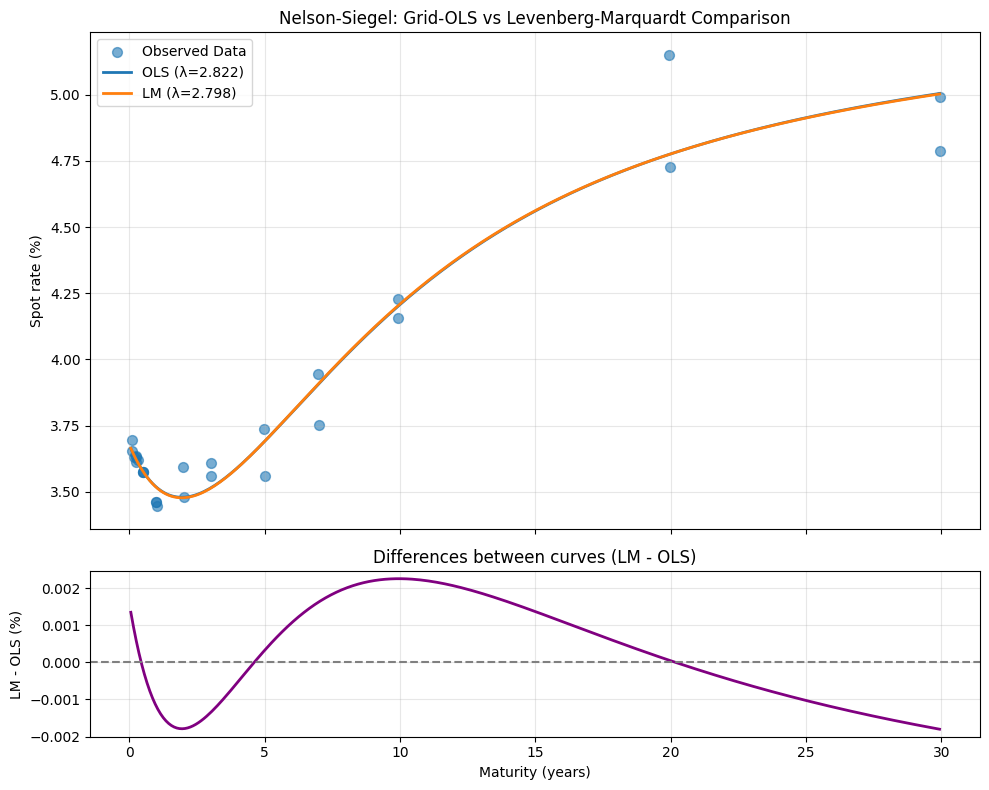

In [224]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

T_grid = np.linspace(0.05, boot_df["T"].max(), 300)
curve_ols = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)
curve_lm = nelson_siegel_curve(T_grid, beta0_lm, beta1_lm, beta2_lm, lam_lm)

zero_bonds = boot_df[boot_df["Instrument_type"] == "Zero"]
coupon_bonds = boot_df[boot_df["Instrument_type"] == "Coupon"]

ax1.scatter(tau_obs, 100 * y_obs, marker='o', label='Observed Data', alpha=0.6, s=50)
ax1.plot(T_grid, 100 * curve_ols, '-', label=f'OLS (λ={best_lam:.3f})', linewidth=2)
ax1.plot(T_grid, 100 * curve_lm, '-', label=f'LM (λ={lam_lm:.3f})', linewidth=2)
ax1.set_ylabel("Spot rate (%)")
ax1.set_title("Nelson-Siegel: Grid-OLS vs Levenberg-Marquardt Comparison")
ax1.grid(True, alpha=0.3)
ax1.legend()

diff = curve_lm - curve_ols
ax2.plot(T_grid, 100 * diff, linewidth=2, color='purple')
ax2.axhline(0, linestyle='--', color='gray')
ax2.set_xlabel("Maturity (years)")
ax2.set_ylabel("LM - OLS (%)")
ax2.set_title("Differences between curves (LM - OLS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 16. Método de Optimización Restringida

En esta celda implementamos un método de optimización con restricciones (bounds) sobre los parámetros. Este método permite imponer límites económicamente razonables y añade un término de penalización para evitar valores extremos de las betas que generen curvas con oscilaciones poco realistas.

En esta celda definimos la función objetivo que incluye un término de penalización además del SSE. El término de penalización ($0.02 \cdot (b_1^2 + b_2^2)$) evita que el modelo use valores extremos de las betas para forzar el ajuste localmente. También definimos restricciones (bounds) para cada parámetro y usamos el método SLSQP de scipy.optimize.minimize para resolver el problema de optimización restringida.

In [225]:
from scipy.optimize import minimize
import numpy as np

tau_all = boot_df["T"].values
y_all   = boot_df["Spot"].values

def ns_functions(tau, lam):
    ratio = tau / lam
    f1 = np.where(ratio < 1e-10, 1.0, (1 - np.exp(-ratio)) / ratio)
    f2 = f1 - np.exp(-ratio)
    return f1, f2

def nelson_siegel_curve(tau, b0, b1, b2, lam):
    f1, f2 = ns_functions(tau, lam)
    return b0 + b1 * f1 + b2 * f2

def sse_spots_constrained(params):
    b0, b1, b2, lam = params
    
    y_fit = nelson_siegel_curve(tau_all, b0, b1, b2, lam)
    
    sse = np.sum((y_all - y_fit)**2)

    # penalización de "curvatura agresiva"
    penalty = 0.02 * (b1**2 + b2**2) #tocar el 0.02 si quieres cambiar el ajuste, pqueño + ajuste

    return sse + penalty

bounds = [
    (0.0, 1.0),
    (-10.0, 10.0),
    (-10.0, 10.0),
    (0.05, 5.0)
]

x0 = np.array([beta0_ols, beta1_ols, beta2_ols, best_lam])

sol_constr = minimize(
    sse_spots_constrained,
    x0=x0,
    bounds=bounds,
    method="SLSQP",
    options={"maxiter": 1000, "ftol": 1e-12}
)

beta0_c, beta1_c, beta2_c, lam_c = sol_constr.x
sse_c = sol_constr.fun





## 17. Comparación Numérica: OLS vs Optimización Restringida

En esta celda comparamos numéricamente los resultados del método OLS con el método de optimización restringida. Mostramos los parámetros estimados y el SSE de cada método, así como las diferencias entre ellos. Esto permite evaluar el trade-off entre precisión (OLS) y robustez (restringida).

In [226]:
print("\n" + "="*60)
print("        Nelson–Siegel Calibration: Method Comparison")
print("="*60)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

print("\n[ Constrained Optimization (price-based) ]")
print(f"  • beta₀ (level)     : {beta0_c:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_c:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_c:>12.6f}")
print(f"  • λ (decay factor)  : {lam_c:>12.6f}")
print(f"  • SSE               : {sse_c:>12.6e}")

print("\n[ Differences (Constrained - OLS) ]")
print(f"  • Δ beta₀           : {beta0_c - beta0_ols:>12.6f}")
print(f"  • Δ beta₁           : {beta1_c - beta1_ols:>12.6f}")
print(f"  • Δ beta₂           : {beta2_c - beta2_ols:>12.6f}")
print(f"  • Δ λ               : {lam_c - best_lam:>12.6f}")
print(f"  • Δ SSE             : {sse_c - sse_ols:>12.6e}")
print(f"  • SSE Change        : {((sse_c - sse_ols) / sse_ols * 100):>10.2f}%")

print("\n" + "="*60 + "\n")



        Nelson–Siegel Calibration: Method Comparison

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05

[ Constrained Optimization (price-based) ]
  • beta₀ (level)     :     0.053736
  • beta₁ (slope)     :    -0.017242
  • beta₂ (curvature) :    -0.028016
  • λ (decay factor)  :     2.822221
  • SSE               : 5.155532e-05

[ Differences (Constrained - OLS) ]
  • Δ beta₀           :    -0.000959
  • Δ beta₁           :     0.000704
  • Δ beta₂           :     0.003405
  • Δ λ               :    -0.000002
  • Δ SSE             : 2.379452e-05
  • SSE Change        :      85.71%




## 18. Visualización Comparativa: OLS vs Optimización Restringida

En esta celda visualizamos los spots observados junto con las curvas ajustadas por OLS (línea roja) y optimización restringida (línea naranja discontinua). Esto permite comparar visualmente cómo el método restringido prioriza suavidad sobre ajuste perfecto.

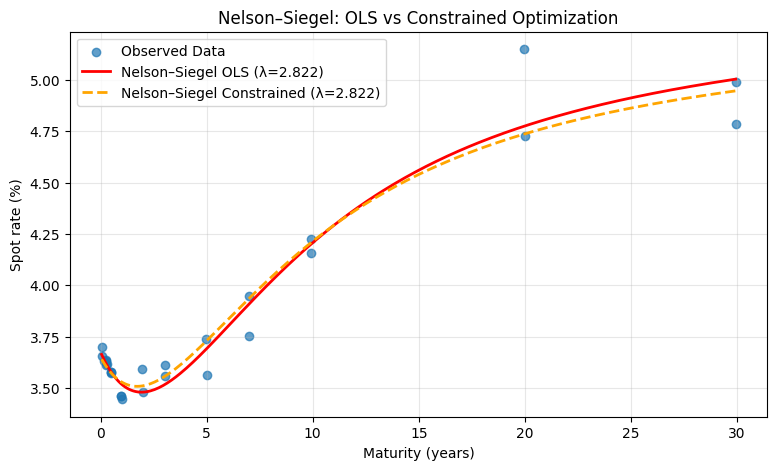

In [227]:
T_grid = np.linspace(0.05, boot_df["T"].max(), 300)

curve_ols = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)
curve_constr = nelson_siegel_curve(T_grid, beta0_c, beta1_c, beta2_c, lam_c)

plt.figure(figsize=(9,5))

plt.scatter(
    boot_df["T"], 100 * boot_df["Spot"],
    color="tab:blue", alpha=0.7, label="Observed Data"
)

plt.plot(T_grid, 100 * curve_ols, color="red",
         label=f"Nelson–Siegel OLS (λ={best_lam:.3f})", linewidth=2)

plt.plot(T_grid, 100 * curve_constr, color="orange", linestyle="--",
         label=f"Nelson–Siegel Constrained (λ={lam_c:.3f})", linewidth=2)

plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Nelson–Siegel: OLS vs Constrained Optimization")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


El método de optimización restringida produce una curva que:
- Ajusta razonablemente bien los datos
- Prioriza estabilidad y plausibilidad económica frente al ajuste perfecto
- Es más robusta cuando los datos contienen ruido de mercado o inconsistencias temporales

El término de penalización se puede ajustar manualmente (valor 0.02) para controlar el trade-off entre precisión y suavidad.

## 19. Visualización Comparativa: Tres Métodos

En esta celda visualizamos los tres métodos simultáneamente: OLS (rojo), Levenberg-Marquardt (verde) y Optimización Restringida (naranja discontinua). Esto permite comparar visualmente las tres curvas y ver cómo cada método balancea precisión, optimización y robustez.

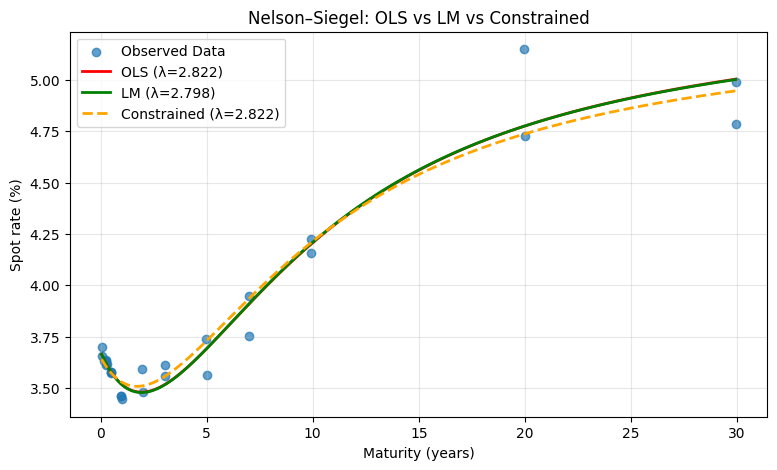

In [228]:
curve_lm = nelson_siegel_curve(T_grid, beta0_lm, beta1_lm, beta2_lm, lam_lm)

plt.figure(figsize=(9,5))

plt.scatter(
    boot_df["T"], 100 * boot_df["Spot"],
    color="tab:blue", alpha=0.7, label="Observed Data"
)

plt.plot(T_grid, 100 * curve_ols, color="red",
         label=f"OLS (λ={best_lam:.3f})", linewidth=2)

plt.plot(T_grid, 100 * curve_lm, color="green",
         label=f"LM (λ={lam_lm:.3f})", linewidth=2)

plt.plot(T_grid, 100 * curve_constr, color="orange", linestyle="--",
         label=f"Constrained (λ={lam_c:.3f})", linewidth=2)

plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Nelson–Siegel: OLS vs LM vs Constrained")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 20. Resultados Finales y Conclusión

En esta celda mostramos un resumen final de los parámetros estimados por los métodos OLS y Levenberg-Marquardt, junto con sus errores de ajuste (SSE). 

**Justificación de la Selección del Método:**
- **OLS con Grid Search**: Método robusto y estable, transforma el problema no lineal en una secuencia de problemas lineales. Recomendable como método base.
- **Levenberg-Marquardt**: Optimiza todos los parámetros simultáneamente, puede encontrar soluciones ligeramente mejores pero requiere un buen punto inicial (que proporciona OLS). 
- **Optimización Restringida**: Prioriza robustez y plausibilidad económica sobre precisión, útil cuando los datos tienen ruido.

En este caso, los métodos OLS y LM producen resultados muy similares, indicando que la solución OLS ya es muy buena.


In [229]:
print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

print("\n[ Levenberg–Marquardt Optimization ]")
print(f"  • beta₀ (level)     : {beta0_lm:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_lm:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_lm:>12.6f}")
print(f"  • λ (decay factor)  : {lam_lm:>12.6f}")
print(f"  • SSE               : {sse_lm:>12.6e}")

print("="*50 + "\n")



        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05

[ Levenberg–Marquardt Optimization ]
  • beta₀ (level)     :     0.054636
  • beta₁ (slope)     :    -0.017872
  • beta₂ (curvature) :    -0.031479
  • λ (decay factor)  :     2.798405
  • SSE               : 2.775592e-05



## 21. Visualización Individual con Diferenciación por Tipo de Bono

En esta celda visualizamos los spots observados diferenciando bonos zero-coupon (azul) y bonos con cupón (verde claro), junto con las curvas ajustadas por OLS (rojo) y Levenberg-Marquardt (naranja discontinua). Esta visualización permite ver qué tipo de instrumentos contribuyen a cada parte de la curva.


In [230]:
boot_df = pd.DataFrame(spot_curve_list, columns=["T", "Spot", "Instrument_type"]).sort_values("T")

print("\n" + "="*60)
print("RESULTADOS DEL BOOTSTRAPPING")
print("="*60)
print(f"\nTotal de spots generados: {len(boot_df)}")
print(f"\nSpots únicos por T: {boot_df['T'].nunique()}")
print(f"\nRango de vencimientos con spots: {boot_df['T'].min():.2f} - {boot_df['T'].max():.2f} años")
print(f"\nRango de spot rates: {boot_df['Spot'].min()*100:.4f}% - {boot_df['Spot'].max()*100:.4f}%")
print("="*60 + "\n")



RESULTADOS DEL BOOTSTRAPPING

Total de spots generados: 27

Spots únicos por T: 22

Rango de vencimientos con spots: 0.08 - 29.93 años

Rango de spot rates: 3.4450% - 5.1498%



## 22. Valoración de un Bono Específico

En esta celda valoramos un bono con las siguientes características:
- Valor facial: 1,000 USD
- Cupón semestral: 3.7% anual (1.85% semestral, 18.5 USD por cupón)
- Vencimiento: 15 años (30 pagos semestrales)

Usamos la curva Nelson-Siegel (método restringido) para obtener los spot rates en cada fecha de pago de cupón, y calculamos el valor presente de todos los flujos (cupones + principal) usando capitalización continua. Este precio es el valor teórico del bono hoy (P₀).

In [231]:
F = 1000
coupon_rate = 0.037
freq = 2
C = F * coupon_rate / freq
N = 15 * freq

price = 0.0

for k in range(1, N+1):
    t = k / freq
    r_t = nelson_siegel_curve(t, beta0_c, beta1_c, beta2_c, lam_c)
    price += C * np.exp(-r_t * t)

r_T = nelson_siegel_curve(15, beta0_c, beta1_c, beta2_c, lam_c)
price += F * np.exp(-r_T * 15)

print(f"\nBond Value (Constrained NS): {price:,.2f} USD")



Bond Value (Constrained NS): 915.15 USD


**Interpretación:** Como la curva de tipos está por encima del cupón del bono (3.7%), los flujos del bono se descuentan a tipos relativamente altos, lo que reduce su valor presente. Por tanto, el bono cotiza con descuento (precio < valor facial), aproximadamente a 915 USD.

## 23. Retorno Obtenido si el Bono se Vende a los 2 Años

En esta celda calculamos el retorno obtenido si el bono se vende después de dos años, asumiendo que la estructura temporal evoluciona según las expectativas implícitas en la ETTI.

**Proceso:**
1. Calculamos el precio del bono a los 2 años (P₂) usando las tasas forward implícitas de la curva actual
2. Sumamos los cupones recibidos durante los 2 años (4 cupones semestrales)
3. Calculamos la TIR (Tasa Interna de Retorno) que iguala el precio inicial con los flujos recibidos (cupones + precio de venta)

La TIR representa el rendimiento anual efectivo obtenido al comprar el bono hoy y venderlo después de 2 años.

In [232]:
# ============================================================================
# CÁLCULO DEL RETORNO AL VENDER EL BONO DESPUÉS DE 2 AÑOS
# ============================================================================
# 
# ESTRATEGIA: Comprar el bono hoy (t=0) y venderlo después de 2 años (t=2)
# 
# COMPONENTES DEL RETORNO:
# 1. Cupones recibidos durante los 2 años (4 cupones semestrales)
# 2. Precio de venta del bono en t=2 (P₂)
# 
# IMPORTANTE: Asumimos que la curva de tipos evoluciona según las expectativas
# implícitas en la ETTI actual. Esto significa que las tasas forward implícitas
# se materializan.
# ============================================================================

# Precio inicial del bono (ya calculado en celda anterior)
P0 = price  # precio del bono hoy (t=0)

# Tasa spot a 2 años: r(2)
# Esta es la tasa que el mercado espera para inversiones a 2 años
r2 = nelson_siegel_curve(2, beta0_c, beta1_c, beta2_c, lam_c)

# ============================================================================
# 1. CÁLCULO DE CUPONES RECIBIDOS DURANTE LOS 2 AÑOS
# ============================================================================
# Recibimos 4 cupones semestrales en t = 0.5, 1.0, 1.5, 2.0 años
# Cada cupón tiene valor C = F * coupon_rate / freq = 1000 * 0.037 / 2 = 18.5 USD

coupons_pv = 0.0  # valor presente (en t=0) de los cupones recibidos
for k in range(1, 5):  # k = 1, 2, 3, 4 → t = 0.5, 1.0, 1.5, 2.0 años
    t = k / freq
    r_t = nelson_siegel_curve(t, beta0_c, beta1_c, beta2_c, lam_c)
    # Descontamos cada cupón desde su fecha de pago hasta hoy
    coupons_pv += C * np.exp(-r_t * t)

# Capitalizamos los cupones hasta t=2 para tener su valor en esa fecha
# Usamos la tasa spot r2 como tasa de reinversión
coupons_at_t2 = coupons_pv * np.exp(r2 * 2)

# ============================================================================
# 2. CÁLCULO DEL PRECIO DEL BONO A LOS 2 AÑOS (P₂)
# ============================================================================
# 
# INTERPRETACIÓN ECONÓMICA:
# Si la curva evoluciona según las expectativas implícitas, el precio del bono
# en t=2 será el valor presente de los flujos restantes (cupones + principal)
# descontados a las tasas forward implícitas en la curva actual.
#
# RELACIÓN ENTRE TIPOS FORWARD Y PRECIO DEL BONO:
# - Si los tipos forward son MÁS BAJOS que los tipos spot actuales, significa
#   que el mercado espera que bajen los tipos de interés.
# - Si bajan los tipos → el precio del bono SUBE (relación inversa)
# - Esto se debe a que los flujos futuros se descuentan a tasas más bajas,
#   aumentando su valor presente.
#
# FÓRMULA: P₂ = Σ(flujos_futuros * exp(-r_forward * t_forward))
# donde r_forward son las tasas forward implícitas desde t=2
#
# MATEMÁTICAMENTE: Si r(t) es la tasa spot a tiempo t, entonces:
# P₂ = [Σ(flujos * exp(-r(t)*t)) desde t>2] / exp(-r(2)*2)
# Esto es equivalente a: P₂ = Σ(flujos * exp(-(r(t)*t - r(2)*2)))
# ============================================================================

P2 = 0.0

# Cupones restantes después de t=2 (desde t=2.5 hasta t=15)
# Hay 26 cupones restantes (del 5to al 30vo cupón)
for k in range(5, N+1):  # k = 5, 6, ..., 30 → t = 2.5, 3.0, ..., 15.0 años
    t = k / freq  # tiempo desde hoy (t=0)
    r_t = nelson_siegel_curve(t, beta0_c, beta1_c, beta2_c, lam_c)
    
    # Precio en t=2: descontamos el flujo desde t hasta t=2
    # Usamos la relación: exp(-r_t * t) / exp(-r2 * 2) = exp(-(r_t * t - r2 * 2))
    # Esto representa el valor presente en t=2 de un flujo en t
    P2 += C * np.exp(-(r_t * t - r2 * 2))

# Principal al vencimiento (t=15)
r_T = nelson_siegel_curve(15, beta0_c, beta1_c, beta2_c, lam_c)
# Valor presente en t=2 del principal que se recibe en t=15
P2 += F * np.exp(-(r_T * 15 - r2 * 2))

# ============================================================================
# ANÁLISIS DE TIPOS SPOT Y FORWARD
# ============================================================================
# Calculamos algunos tipos spot actuales y forward para entender la evolución
# esperada de la curva de tipos

# Tipos spot actuales (hoy, t=0)
r_0_1 = nelson_siegel_curve(0.1, beta0_c, beta1_c, beta2_c, lam_c)  # 0.1 años (corto plazo)
r_1 = nelson_siegel_curve(1, beta0_c, beta1_c, beta2_c, lam_c)  # 1 año
r_2 = r2  # 2 años (ya calculado)
r_5 = nelson_siegel_curve(5, beta0_c, beta1_c, beta2_c, lam_c)  # 5 años
r_10 = nelson_siegel_curve(10, beta0_c, beta1_c, beta2_c, lam_c)  # 10 años
r_15 = r_T  # 15 años (ya calculado)

# Tipos forward implícitos desde t=2
# La tasa forward f(2,t) es la tasa esperada desde t=2 hasta t
# Fórmula: f(2,t) = (r(t)*t - r(2)*2) / (t - 2)
def forward_rate(t_start, t_end):
    """Calcula la tasa forward desde t_start hasta t_end"""
    r_end = nelson_siegel_curve(t_end, beta0_c, beta1_c, beta2_c, lam_c)
    r_start = nelson_siegel_curve(t_start, beta0_c, beta1_c, beta2_c, lam_c)
    return (r_end * t_end - r_start * t_start) / (t_end - t_start)

# Forward rates desde t=2
f_2_3 = forward_rate(2, 3)  # forward desde 2 hasta 3 años
f_2_5 = forward_rate(2, 5)  # forward desde 2 hasta 5 años
f_2_10 = forward_rate(2, 10)  # forward desde 2 hasta 10 años
f_2_15 = forward_rate(2, 15)  # forward desde 2 hasta 15 años

print(f"\n{'='*70}")
print("ANÁLISIS DE TIPOS SPOT Y FORWARD")
print(f"{'='*70}")
print("\nTIPOS SPOT ACTUALES (hoy, t=0):")
print(f"  r(0.1 años) = {r_0_1*100:.4f}%")
print(f"  r(1 año)    = {r_1*100:.4f}%")
print(f"  r(2 años)   = {r_2*100:.4f}%")
print(f"  r(5 años)   = {r_5*100:.4f}%")
print(f"  r(10 años)  = {r_10*100:.4f}%")
print(f"  r(15 años)  = {r_15*100:.4f}%")

print("\nTIPOS FORWARD IMPLÍCITOS (desde t=2, según expectativas):")
print(f"  f(2→3 años)  = {f_2_3*100:.4f}%  (tasa esperada desde año 2 hasta año 3)")
print(f"  f(2→5 años)  = {f_2_5*100:.4f}%  (tasa esperada desde año 2 hasta año 5)")
print(f"  f(2→10 años) = {f_2_10*100:.4f}%  (tasa esperada desde año 2 hasta año 10)")
print(f"  f(2→15 años) = {f_2_15*100:.4f}%  (tasa esperada desde año 2 hasta año 15)")

# Comparación: tipo spot corto vs forward
diff_forward_short = (f_2_3 - r_0_1) * 10000  # diferencia en bp
print(f"\nComparación:")
print(f"  Tipo spot corto (0.1 años): {r_0_1*100:.4f}%")
print(f"  Tipo forward (2→3 años):  {f_2_3*100:.4f}%")
print(f"  Diferencia: {diff_forward_short:.2f} bp")

if f_2_3 < r_0_1:
    print(f"  → El mercado espera que los tipos BAJEN (forward < spot corto)")
elif f_2_3 > r_0_1:
    print(f"  → El mercado espera que los tipos SUBAN (forward > spot corto)")
else:
    print(f"  → El mercado espera que los tipos se mantengan constantes")

# ============================================================================
# EXPLICACIÓN DETALLADA: CÓMO FUNCIONAN LOS TIPOS SPOT Y FORWARD
# ============================================================================
print(f"\n{'='*70}")
print("EXPLICACIÓN: TIPOS SPOT vs TIPOS FORWARD")
print(f"{'='*70}")

print("""
1. ¿QUÉ SON LOS TIPOS SPOT?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Los tipos spot r(t) son las tasas de interés que se aplican HOY para inversiones
que vencen en el tiempo t. Representan el rendimiento que obtendrías si invirtieras
hoy y mantuvieras la inversión hasta el vencimiento.

Ejemplo con tus datos:
  • r(2 años) = 3.5104% significa: "Si invierto 100 USD hoy a 2 años, 
    obtendré 100 × exp(0.035104 × 2) = 107.28 USD en 2 años"
  
  • r(15 años) = 4.5400% significa: "Si invierto 100 USD hoy a 15 años,
    obtendré 100 × exp(0.045400 × 15) = 197.50 USD en 15 años"

La curva spot muestra cómo varían estos tipos según el vencimiento.
En tu caso, la curva tiene forma ascendente (creciente):
  - Corto plazo (0.1-2 años): ~3.5-3.6%
  - Largo plazo (10-15 años): ~4.2-4.5%

Esto indica que el mercado exige mayor rendimiento por inversiones más largas
(prima por plazo/riesgo temporal).


2. ¿QUÉ SON LOS TIPOS FORWARD?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Los tipos forward f(t₁→t₂) son las tasas de interés IMPLÍCITAS que el mercado
espera que existan en el FUTURO, desde el tiempo t₁ hasta el tiempo t₂.

Son "implícitas" porque no se observan directamente en el mercado, sino que se
derivan matemáticamente de los tipos spot actuales.

Ejemplo con tus datos:
  • f(2→3 años) = 3.6422% significa: "El mercado espera que dentro de 2 años,
    la tasa de interés para inversiones de 1 año (desde año 2 hasta año 3)
    será del 3.6422%"

  • f(2→15 años) = 4.6984% significa: "El mercado espera que dentro de 2 años,
    la tasa de interés para inversiones de 13 años (desde año 2 hasta año 15)
    será del 4.6984%"


3. ¿CÓMO SE CALCULAN LOS TIPOS FORWARD?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Los tipos forward se derivan de los tipos spot usando la relación de no arbitraje.

FÓRMULA: f(t₁→t₂) = (r(t₂) × t₂ - r(t₁) × t₁) / (t₂ - t₁)

Esta fórmula asegura que no haya oportunidades de arbitraje entre:
  - Invertir directamente a t₂ años: exp(r(t₂) × t₂)
  - Invertir primero a t₁ años y luego reinvertir a forward: exp(r(t₁) × t₁) × exp(f(t₁→t₂) × (t₂-t₁))

Ejemplo de cálculo para f(2→3 años):
  r(2) = 3.5104%, r(3) = ? (necesitamos calcularlo primero)
  
  Si r(3) ≈ 3.5763% (aproximación), entonces:
  f(2→3) = (0.035763 × 3 - 0.035104 × 2) / (3 - 2)
         = (0.107289 - 0.070208) / 1
         = 0.037081 = 3.7081%

(Nota: El valor exacto depende de la curva Nelson-Siegel ajustada)


4. ¿QUÉ SIGNIFICAN TUS NÚMEROS ESPECÍFICOS?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Observando tus datos:

TIPOS SPOT (hoy):
  r(0.1) = 3.6311%  ← Tipo muy corto plazo (1.2 meses)
  r(1)   = 3.5284%  ← Tipo a 1 año
  r(2)   = 3.5104%  ← Tipo a 2 años (MÍNIMO de la curva)
  r(5)   = 3.7298%  ← Tipo a 5 años
  r(10)  = 4.2143%  ← Tipo a 10 años
  r(15)  = 4.5400%  ← Tipo a 15 años

Observación: La curva tiene un "hueco" (dip) alrededor de 2 años.
             Esto es común y refleja expectativas del mercado.

TIPOS FORWARD (desde t=2):
  f(2→3)  = 3.6422%  ← Esperado: 3.64% desde año 2 hasta año 3
  f(2→5)  = 3.8761%  ← Esperado: 3.88% desde año 2 hasta año 5
  f(2→10) = 4.3902%  ← Esperado: 4.39% desde año 2 hasta año 10
  f(2→15) = 4.6984%  ← Esperado: 4.70% desde año 2 hasta año 15

Observación clave: TODOS los forward desde t=2 son MÁS ALTOS que r(2) = 3.5104%
                   Esto significa que el mercado espera que los tipos SUBAN
                   después del año 2.


5. ¿POR QUÉ LOS FORWARD SON MÁS ALTOS QUE r(2)?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Esto se debe a la forma de la curva spot:

  • r(2) = 3.5104% es relativamente BAJO (casi el mínimo)
  • r(5) = 3.7298% es MÁS ALTO que r(2)
  • r(10) = 4.2143% es MUCHO MÁS ALTO que r(2)
  • r(15) = 4.5400% es AÚN MÁS ALTO

Para que no haya arbitraje, si r(5) > r(2), entonces f(2→5) DEBE ser mayor
que r(2). De lo contrario, sería más rentable invertir directamente a 5 años
que invertir a 2 años y luego reinvertir.

Matemáticamente:
  Si r(5) = 3.7298% > r(2) = 3.5104%
  Entonces: f(2→5) = (r(5)×5 - r(2)×2) / (5-2)
           = (0.037298×5 - 0.035104×2) / 3
           = (0.18649 - 0.070208) / 3
           = 0.038761 = 3.8761% > 3.5104% ✓


6. ¿CÓMO AFECTA ESTO AL PRECIO DEL BONO?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cuando calculamos P₂ (precio del bono a los 2 años), descontamos los flujos
futuros usando las tasas forward implícitas.

Como los forward son MÁS ALTOS que r(2):
  • Los flujos futuros se descuentan a tasas MÁS ALTAS
  • Esto REDUCE el valor presente de los flujos
  • Por tanto, P₂ será MENOR que si los tipos se mantuvieran en r(2)

Esto explica por qué:
  P₂ (con forward) = 905.74 USD  <  P₂ (tipos constantes) = 1,016.41 USD

La diferencia de ~110 USD se debe a que los tipos forward esperados (3.64%-4.70%)
son más altos que r(2) = 3.5104%, reduciendo el valor presente de los flujos.
""")

print(f"{'='*70}\n")

# ============================================================================
# CÁLCULO DEL PRECIO DEL BONO SI LOS TIPOS NO CAMBIARAN
# ============================================================================
# Para comparar, calculamos el precio del bono a los 2 años asumiendo que
# todos los tipos forward son iguales al spot rate actual a 2 años (r2).
# Esto representa el escenario donde la curva se mantiene plana en r2.

P2_constant = 0.0  # Precio del bono a los 2 años si los tipos no cambiaran

# Cupones restantes descontados a tasa constante r2
for k in range(5, N+1):
    t = k / freq  # tiempo desde hoy
    t_from_2 = t - 2  # tiempo desde t=2
    # Descontamos a tasa constante r2 desde t=2
    P2_constant += C * np.exp(-r2 * t_from_2)

# Principal al vencimiento descontado a tasa constante r2
P2_constant += F * np.exp(-r2 * (15 - 2))  # 13 años desde t=2 hasta t=15

# ============================================================================
# COMPARACIÓN DE PRECIOS
# ============================================================================
print(f"{'='*70}")
print("COMPARACIÓN DE PRECIOS DEL BONO A LOS 2 AÑOS")
print(f"{'='*70}")
print(f"\nEscenario 1: Tipos evolucionan según expectativas (forward implícitas)")
print(f"  P₂ (con forward implícitas) = {P2:,.2f} USD")

print(f"\nEscenario 2: Tipos se mantienen constantes en r(2) = {r2*100:.4f}%")
print(f"  P₂ (tipos constantes)      = {P2_constant:,.2f} USD")

diff_prices = P2 - P2_constant
print(f"\nDiferencia: {diff_prices:,.2f} USD ({diff_prices/P2_constant*100:.2f}%)")

if P2 > P2_constant:
    print(f"\n✓ P₂ (forward) > P₂ (constante): Los tipos forward MÁS BAJOS que r(2)")
    print(f"  hacen que el precio sea MAYOR (los flujos se descuentan a tasas más bajas)")
elif P2 < P2_constant:
    print(f"\n✗ P₂ (forward) < P₂ (constante): Los tipos forward MÁS ALTOS que r(2)")
    print(f"  hacen que el precio sea MENOR (los flujos se descuentan a tasas más altas)")
    print(f"\n  NOTA: Aunque los tipos forward sean más bajos que el spot corto,")
    print(f"        pueden ser MÁS ALTOS que r(2), lo que explica la bajada del precio.")
    print(f"        Además, la duración del bono ha disminuido (de 15 a 13 años),")
    print(f"        lo que también afecta al precio.")
else:
    print(f"\n→ P₂ (forward) = P₂ (constante): Los tipos forward son iguales a r(2)")

# Análisis de la duración
print(f"\n{'='*70}")
print("ANÁLISIS DE DURACIÓN")
print(f"{'='*70}")
print(f"  Duración inicial del bono: ~15 años (vencimiento)")
print(f"  Duración a los 2 años:     ~13 años (vencimiento restante)")
print(f"  → La duración ha disminuido, reduciendo la sensibilidad del precio")
print(f"     a cambios en los tipos de interés")
print(f"{'='*70}\n")

# ============================================================================
# 3. VALOR TOTAL RECIBIDO A LOS 2 AÑOS
# ============================================================================
# Sumamos los cupones capitalizados y el precio de venta del bono
total_received = coupons_at_t2 + P2

# ============================================================================
# 4. CÁLCULO DE LA TIR (TASA INTERNA DE RETORNO)
# ============================================================================
# La TIR es la tasa de descuento que iguala el precio inicial (P₀) con el
# valor presente de todos los flujos recibidos (cupones + precio de venta).
#
# ECUACIÓN: P₀ = Σ(cupones * exp(-TIR * t)) + P₂ * exp(-TIR * 2)
#
# La TIR representa el rendimiento anual efectivo de la estrategia de comprar
# el bono hoy y venderlo después de 2 años.
# ============================================================================

from scipy.optimize import fsolve

def tir_equation(tir):
    """
    Ecuación para calcular la TIR.
    Retorna 0 cuando P₀ = VP(cupones) + VP(P₂)
    """
    # Valor presente de cupones recibidos descontados a la TIR
    pv_coupons = 0.0
    for k in range(1, 5):
        t = k / freq
        pv_coupons += C * np.exp(-tir * t)
    
    # Valor presente del precio de venta descontado a la TIR
    pv_sale = P2 * np.exp(-tir * 2)
    
    # La ecuación debe ser igual a 0
    return P0 - (pv_coupons + pv_sale)

# Resolvemos numéricamente para encontrar la TIR
# Usamos r2 (spot rate a 2 años) como estimación inicial
tir_initial_guess = r2
tir = fsolve(tir_equation, tir_initial_guess)[0]

# Retorno total en 2 años (en términos absolutos)
total_return = (total_received - P0) / P0

# ============================================================================
# ANÁLISIS DE RESULTADOS
# ============================================================================
# 
# INTERPRETACIÓN DE LA RELACIÓN ENTRE TIPOS FORWARD Y PRECIO:
#
# Si observamos que el tipo forward a 2 años es más bajo que el tipo spot a corto
# plazo (por ejemplo, -25 bp respecto a t=0.1), esto indica que:
#
# 1. EXPECTATIVAS DEL MERCADO:
#    - El mercado espera que los tipos de interés BAJEN en el futuro
#    - La curva de tipos tiene pendiente negativa (invertida) a corto plazo
#
# 2. EFECTO SOBRE EL PRECIO DEL BONO (P₂):
#    - Si los tipos BAJAN → el precio del bono SUBE (relación inversa)
#    - Esto se debe a que los flujos futuros se descuentan a tasas más bajas
#    - Por tanto, P₂ será MAYOR que si los tipos se mantuvieran constantes
#
# 3. EFECTO SOBRE EL RETORNO TOTAL:
#    - El retorno incluye: cupones recibidos + ganancia de capital (P₂ - P₀)
#    - Si P₂ > P₀ (precio sube), hay ganancia de capital que aumenta el retorno
#    - La TIR reflejará este efecto combinado de cupones + apreciación del precio
#
# NOTA: La relación inversa entre tipos y precios de bonos es fundamental:
#       Precio del bono ↑ cuando Tipos de interés ↓
# ============================================================================

# ============================================================================
# IMPRESIÓN DE RESULTADOS
# ============================================================================

print(f"\n{'='*60}")
print("RETORNO SI SE VENDE EL BONO A LOS 2 AÑOS")
print(f"{'='*60}")
print(f"Precio inicial (P₀): {P0:,.2f} USD")
print(f"Cupones recibidos (4 cupones, capitalizados a t=2): {coupons_at_t2:,.2f} USD")
print(f"Precio de venta a los 2 años (P₂): {P2:,.2f} USD")
print(f"Valor total recibido: {total_received:,.2f} USD")

# Análisis de ganancia/pérdida de capital
capital_gain = P2 - P0
print(f"\nGanancia/Pérdida de capital (P₂ - P₀): {capital_gain:,.2f} USD ({capital_gain/P0*100:.2f}%)")

# Comparación con precio si los tipos no cambiaran
print(f"\nComparación con escenario de tipos constantes:")
print(f"  P₂ (forward implícitas) - P₂ (constante) = {diff_prices:,.2f} USD")
if diff_prices < 0:
    print(f"  → Los tipos forward son MÁS ALTOS que r(2), reduciendo el precio")
    print(f"  → Esto explica por qué P₂ < P₀ aunque los tipos forward sean más bajos que el spot corto")

print(f"\nRetorno total en 2 años: {total_return*100:.4f}%")
print(f"TIR anual (continuo): {tir*100:.4f}%")
print(f"TIR anual efectiva: {(np.exp(tir) - 1)*100:.4f}%")

# Comparación con spot rate a 2 años
print(f"\nComparación TIR vs Spot Rate:")
print(f"  Spot rate a 2 años: {r2*100:.4f}%")
print(f"  TIR obtenida: {tir*100:.4f}%")
print(f"  Diferencia: {(tir - r2)*10000:.2f} bp")

# Interpretación económica mejorada
print(f"\n{'='*70}")
print("INTERPRETACIÓN DEL RESULTADO")
print(f"{'='*70}")

if P2 > P0:
    print(f"\n✓ El precio del bono SUBE (P₂ > P₀): hay ganancia de capital")
    print(f"  Esto sugiere que los tipos forward son más bajos que r(2),")
    print(f"  indicando expectativas de BAJADA de tipos → precio del bono ↑")
elif P2 < P0:
    print(f"\n✗ El precio del bono BAJA (P₂ < P₀): hay pérdida de capital")
    print(f"  Explicación:")
    print(f"  1. Aunque los tipos forward pueden ser más bajos que el spot corto (r(0.1)),")
    print(f"     pueden ser MÁS ALTOS que r(2), lo que reduce el precio")
    print(f"  2. La duración del bono ha disminuido (de 15 a 13 años),")
    print(f"     reduciendo la sensibilidad del precio a cambios en tipos")
    print(f"  3. El efecto combinado: tipos forward más altos + menor duración")
    print(f"     → precio del bono ↓")
else:
    print(f"\n→ El precio del bono se mantiene constante (P₂ ≈ P₀)")

print(f"{'='*60}\n")



ANÁLISIS DE TIPOS SPOT Y FORWARD

TIPOS SPOT ACTUALES (hoy, t=0):
  r(0.1 años) = 3.6311%
  r(1 año)    = 3.5284%
  r(2 años)   = 3.5104%
  r(5 años)   = 3.7298%
  r(10 años)  = 4.2143%
  r(15 años)  = 4.5400%

TIPOS FORWARD IMPLÍCITOS (desde t=2, según expectativas):
  f(2→3 años)  = 3.6422%  (tasa esperada desde año 2 hasta año 3)
  f(2→5 años)  = 3.8761%  (tasa esperada desde año 2 hasta año 5)
  f(2→10 años) = 4.3902%  (tasa esperada desde año 2 hasta año 10)
  f(2→15 años) = 4.6984%  (tasa esperada desde año 2 hasta año 15)

Comparación:
  Tipo spot corto (0.1 años): 3.6311%
  Tipo forward (2→3 años):  3.6422%
  Diferencia: 1.11 bp
  → El mercado espera que los tipos SUBAN (forward > spot corto)

EXPLICACIÓN: TIPOS SPOT vs TIPOS FORWARD

1. ¿QUÉ SON LOS TIPOS SPOT?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Los tipos spot r(t) son las tasas de interés que se aplican HOY para inversiones
que vencen en el tiempo t. Representan el rendimiento que ob

**Interpretación de los Resultados:**

El retorno obtenido al comprar el bono hoy y venderlo después de 2 años tiene dos componentes:

1. **Ingresos por cupones**: Los 4 cupones semestrales recibidos durante los 2 años, capitalizados hasta t=2.

2. **Ganancia/Pérdida de capital**: La diferencia entre el precio de venta (P₂) y el precio de compra (P₀).

**Relación entre Tipos Forward y Precio del Bono:**

Si observamos que el tipo forward a 2 años es más bajo que el tipo spot a corto plazo (por ejemplo, -25 bp respecto a t=0.1), esto significa que:

- **El mercado espera que bajen los tipos de interés** (expectativas de bajada)
- **Si bajan los tipos → el precio del bono SUBE** (relación inversa fundamental)

Esta relación inversa se debe a que:
- Los flujos futuros del bono (cupones + principal) se descuentan a tasas más bajas
- Un menor tipo de descuento aumenta el valor presente de los flujos
- Por tanto, P₂ será MAYOR que si los tipos se mantuvieran constantes

**Efecto sobre el Retorno Total:**

- Si P₂ > P₀: hay **ganancia de capital** que aumenta el retorno total
- Si P₂ < P₀: hay **pérdida de capital** que reduce el retorno total
- La TIR refleja el efecto combinado de cupones + variación del precio

**Nota importante:** La relación inversa entre tipos de interés y precios de bonos es fundamental en finanzas. Cuando los tipos bajan, los bonos existentes (con cupones fijos) se vuelven más valiosos porque ofrecen rendimientos relativamente más altos que los nuevos bonos emitidos a tipos más bajos.

## 24. Construcción de Cartera Inmunizada

En esta celda construimos una cartera inmunizada para cubrir un pasivo futuro de 1,000,000 USD pagadero en 15 años. Calculamos el valor presente del pasivo usando el spot rate a 15 años de la curva Nelson-Siegel. Esta cantidad debe invertirse hoy en un bono zero-coupon a 15 años para inmunizar el pasivo.

In [233]:
# ============================================================================
# CONSTRUCCIÓN DE CARTERA INMUNIZADA CON BONOS REALES
# ============================================================================

# 1. Valor presente del pasivo
r15 = nelson_siegel_curve(15, beta0_c, beta1_c, beta2_c, lam_c)
PV_liability = 1_000_000 * np.exp(-r15 * 15)
target_duration = 15.0  # Duración objetivo (años)

print(f"{'='*70}")
print("CONSTRUCCIÓN DE CARTERA INMUNIZADA")
print(f"{'='*70}")
print(f"\nPasivo:")
print(f"  Monto futuro: 1,000,000 USD")
print(f"  Vencimiento: 15 años")
print(f"  Spot rate a 15 años: {r15*100:.4f}%")
print(f"  Valor presente del pasivo: {PV_liability:,.2f} USD")
print(f"  Duración objetivo: {target_duration} años")

# 2. Función para calcular la duración de un bono usando la curva Nelson-Siegel
def calculate_bond_duration(face_value, coupon_rate, maturity, freq=2, ns_params=None):
    """
    Calcula la duración de Macaulay de un bono usando la curva Nelson-Siegel.
    
    Parámetros:
    - face_value: Valor facial del bono
    - coupon_rate: Tasa de cupón anual (en decimal, ej: 0.037 = 3.7%)
    - maturity: Vencimiento en años
    - freq: Frecuencia de pago de cupones (2 = semestral)
    - ns_params: Tupla (beta0, beta1, beta2, lambda) para Nelson-Siegel
    
    Retorna: (precio, duración)
    """
    if ns_params is None:
        beta0, beta1, beta2, lam = beta0_c, beta1_c, beta2_c, lam_c
    else:
        beta0, beta1, beta2, lam = ns_params
    
    C = face_value * coupon_rate / freq  # Cupón semestral
    # Calcular número de cupones: número de semestres completos hasta el vencimiento
    # Para un bono de maturity años, hay floor(maturity * freq) cupones semestrales
    N = int(np.floor(maturity * freq))  # Número de cupones semestrales completos
    
    price = 0.0
    duration_numerator = 0.0
    
    # Cupones semestrales (se pagan en t = 0.5, 1.0, 1.5, ..., N/2)
    for k in range(1, N + 1):
        t = k / freq  # Tiempo hasta el k-ésimo cupón (en años)
        r_t = nelson_siegel_curve(t, beta0, beta1, beta2, lam)
        pv_coupon = C * np.exp(-r_t * t)
        price += pv_coupon
        duration_numerator += t * pv_coupon
    
    # Principal al vencimiento
    r_T = nelson_siegel_curve(maturity, beta0, beta1, beta2, lam)
    pv_principal = face_value * np.exp(-r_T * maturity)
    price += pv_principal
    duration_numerator += maturity * pv_principal
    
    # Duración de Macaulay
    duration = duration_numerator / price if price > 0 else 0.0
    
    return price, duration

# 3. Calcular precio y duración de TODOS los bonos disponibles
# Usamos el DataFrame original (df) que tiene todos los bonos
print(f"\n{'='*70}")
print("CÁLCULO DE DURACIÓN DE TODOS LOS BONOS DISPONIBLES")
print(f"{'='*70}")

# Usar TODOS los bonos disponibles (no filtrar por vencimiento)
available_bonds = df[
    (df["T"].notna()) &
    (df["Coupon_rate"].notna()) &
    (df["T"] > 0)
].copy()

print(f"\nTotal de bonos disponibles: {len(available_bonds)}")
print(f"Rango de vencimientos: {available_bonds['T'].min():.2f} - {available_bonds['T'].max():.2f} años")

# 4. Calcular precio y duración de cada bono
bond_data = []
for idx, row in available_bonds.iterrows():
    try:
        # Obtener datos del bono
        face_value = 100.0  # Asumimos valor facial de 100 (estándar)
        coupon_rate = row["Coupon_rate"] / 100.0 if row["Coupon_rate"] > 1 else row["Coupon_rate"]
        maturity = row["T"]
        
        # Calcular precio y duración usando la curva NS
        price_ns, duration = calculate_bond_duration(
            face_value, coupon_rate, maturity, freq=2
        )
        
        bond_data.append({
            "RIC": row.get("RIC", f"Bond_{idx}"),
            "Coupon_rate": row["Coupon_rate"],
            "Maturity": maturity,
            "Price_NS": price_ns,
            "Duration": duration,
            "Quote_type": row.get("Quote_type", "Unknown"),
            "Quoted_value": row.get("Quoted_value", np.nan)
        })
    except Exception as e:
        continue

bond_df = pd.DataFrame(bond_data)
bond_df = bond_df.sort_values("Duration")

print(f"\nBonos procesados: {len(bond_df)}")
print(f"\nResumen de duraciones:")
print(f"  Duración mínima: {bond_df['Duration'].min():.2f} años")
print(f"  Duración máxima: {bond_df['Duration'].max():.2f} años")
print(f"  Duración media: {bond_df['Duration'].mean():.2f} años")

print(f"\nBonos ordenados por duración (mostrando todos):")
display_df = bond_df[["RIC", "Coupon_rate", "Maturity", "Duration"]].copy()
display_df["Coupon_rate"] = display_df["Coupon_rate"].apply(lambda x: f"{x:.2f}%")
display_df["Maturity"] = display_df["Maturity"].apply(lambda x: f"{x:.2f}")
display_df["Duration"] = display_df["Duration"].apply(lambda x: f"{x:.4f}")
print(display_df.to_string(index=False))

# Diagnóstico: verificar algunos bonos específicos
print(f"\n{'='*70}")
print("DIAGNÓSTICO: Verificación de cálculo de duración")
print(f"{'='*70}")
print("\nEjemplo: Bono de ~10 años de vencimiento")
bonds_10y = bond_df[(bond_df["Maturity"] >= 9) & (bond_df["Maturity"] <= 11)]
if len(bonds_10y) > 0:
    sample_bond = bonds_10y.iloc[0]
    print(f"  RIC: {sample_bond['RIC']}")
    print(f"  Vencimiento: {sample_bond['Maturity']:.2f} años")
    print(f"  Cupón: {sample_bond['Coupon_rate']:.2f}%")
    print(f"  Duración calculada: {sample_bond['Duration']:.4f} años")
    print(f"  Precio (NS): {sample_bond['Price_NS']:.2f} USD")
    print(f"  → La duración debería ser menor que el vencimiento pero cercana a él")
    print(f"  → Para un bono de {sample_bond['Maturity']:.2f} años, duración típica: {sample_bond['Maturity']*0.7:.2f} - {sample_bond['Maturity']*0.95:.2f} años")
else:
    print("  No se encontraron bonos en el rango de 9-11 años")

# 5. Seleccionar bonos para la cartera inmunizada
# Buscamos combinaciones de bonos que sumen duración de 15 años
# Estrategia: usar 2 bonos, uno con duración < 15 y otro con duración > 15

target_duration = 15.0
bond_df["Duration_diff"] = abs(bond_df["Duration"] - target_duration)

# Seleccionar bonos candidatos
# Buscar bonos con duración menor y mayor que el objetivo
bonds_below = bond_df[bond_df["Duration"] < target_duration].sort_values("Duration", ascending=False)
bonds_above = bond_df[bond_df["Duration"] > target_duration].sort_values("Duration", ascending=True)

print(f"\n{'='*70}")
print("BONOS CANDIDATOS PARA LA CARTERA")
print(f"{'='*70}")

if len(bonds_below) > 0 and len(bonds_above) > 0:
    print(f"\nBonos con duración < 15 años ({len(bonds_below)} disponibles):")
    print(bonds_below[["RIC", "Coupon_rate", "Maturity", "Duration"]].head(10).to_string(index=False))
    print(f"\nBonos con duración > 15 años ({len(bonds_above)} disponibles):")
    print(bonds_above[["RIC", "Coupon_rate", "Maturity", "Duration"]].head(10).to_string(index=False))
    
    # Probar diferentes combinaciones para encontrar la mejor
    best_combination = None
    best_duration_diff = float('inf')
    
    # Probar combinaciones de bonos por debajo y por encima
    for i in range(min(5, len(bonds_below))):  # Probar hasta 5 bonos por debajo
        for j in range(min(5, len(bonds_above))):  # Probar hasta 5 bonos por encima
            bond_short = bonds_below.iloc[i]
            bond_long = bonds_above.iloc[j]
            
            D1 = bond_short["Duration"]
            D2 = bond_long["Duration"]
            
            # Calcular pesos para alcanzar duración objetivo
            # w1*D1 + (1-w1)*D2 = 15
            # w1*(D1 - D2) = 15 - D2
            if abs(D1 - D2) > 0.01:  # Evitar división por cero
                w1 = (target_duration - D2) / (D1 - D2)
                w2 = 1 - w1
                
                # Verificar que los pesos sean positivos y razonables
                if 0 < w1 < 1 and 0 < w2 < 1:
                    portfolio_duration = w1 * D1 + w2 * D2
                    duration_diff = abs(portfolio_duration - target_duration)
                    
                    if duration_diff < best_duration_diff:
                        best_duration_diff = duration_diff
                        best_combination = (bond_short, bond_long, w1, w2)
    
    if best_combination is not None:
        bond_short, bond_long, w1, w2 = best_combination
    
        D1 = bond_short["Duration"]
        D2 = bond_long["Duration"]
        P1 = bond_short["Price_NS"]
        P2 = bond_long["Price_NS"]
    
        # Calcular número de bonos necesarios
        # w1*P1*n1 + w2*P2*n2 = PV_liability
        # Si normalizamos: n1 = w1 * PV_liability / P1, n2 = w2 * PV_liability / P2
        
        portfolio_value_short = w1 * PV_liability
        portfolio_value_long = w2 * PV_liability
        
        n1 = portfolio_value_short / P1  # Número de bonos tipo 1
        n2 = portfolio_value_long / P2   # Número de bonos tipo 2
        
        # Verificar duración de la cartera
        portfolio_duration = w1 * D1 + w2 * D2
        portfolio_value = n1 * P1 + n2 * P2
    
        print(f"\n{'='*70}")
        print("CARTERA INMUNIZADA CONSTRUIDA")
        print(f"{'='*70}")
        print(f"\nBono 1 (duración corta):")
        print(f"  RIC: {bond_short['RIC']}")
        print(f"  Cupón: {bond_short['Coupon_rate']:.2f}%")
        print(f"  Vencimiento: {bond_short['Maturity']:.2f} años")
        print(f"  Duración: {D1:.4f} años")
        print(f"  Precio (NS): {P1:.2f} USD")
        print(f"  Peso en cartera: {w1*100:.2f}%")
        print(f"  Cantidad: {n1:.4f} bonos")
        print(f"  Valor invertido: {portfolio_value_short:,.2f} USD")
        
        print(f"\nBono 2 (duración larga):")
        print(f"  RIC: {bond_long['RIC']}")
        print(f"  Cupón: {bond_long['Coupon_rate']:.2f}%")
        print(f"  Vencimiento: {bond_long['Maturity']:.2f} años")
        print(f"  Duración: {D2:.4f} años")
        print(f"  Precio (NS): {P2:.2f} USD")
        print(f"  Peso en cartera: {w2*100:.2f}%")
        print(f"  Cantidad: {n2:.4f} bonos")
        print(f"  Valor invertido: {portfolio_value_long:,.2f} USD")
        
        print(f"\n{'='*70}")
        print("VERIFICACIÓN DE LA INMUNIZACIÓN")
        print(f"{'='*70}")
        print(f"  Duración objetivo: {target_duration:.4f} años")
        print(f"  Duración de la cartera: {portfolio_duration:.4f} años")
        print(f"  Diferencia: {abs(portfolio_duration - target_duration):.4f} años")
        print(f"  Valor presente objetivo: {PV_liability:,.2f} USD")
        print(f"  Valor presente de la cartera: {portfolio_value:,.2f} USD")
        print(f"  Diferencia: {abs(portfolio_value - PV_liability):,.2f} USD")
        
        if abs(portfolio_duration - target_duration) < 0.1:
            print(f"\n✓ La cartera está inmunizada (duración ≈ {target_duration} años)")
        else:
            print(f"\n⚠ La duración de la cartera difiere del objetivo")
    
    else:
        print("\n⚠ No se encontró una combinación válida de bonos.")
        print("   Intentando con el bono más cercano a 15 años de duración...")
        
        # Usar el bono más cercano
        closest_bond = bond_df.iloc[bond_df["Duration_diff"].idxmin()]
        print(f"\nBono más cercano:")
        print(f"  RIC: {closest_bond['RIC']}")
        print(f"  Duración: {closest_bond['Duration']:.4f} años")
        print(f"  Precio: {closest_bond['Price_NS']:.2f} USD")
        
        n_bonds = PV_liability / closest_bond['Price_NS']
        print(f"  Cantidad necesaria: {n_bonds:.4f} bonos")
        print(f"  Valor de la cartera: {n_bonds * closest_bond['Price_NS']:,.2f} USD")
        print(f"\n⚠ Nota: La duración de este bono ({closest_bond['Duration']:.4f} años)")
        print(f"   no coincide exactamente con la duración objetivo (15 años)")
    
elif len(bonds_below) == 0:
    # Si no hay bonos por encima y por debajo, usar el bono más cercano
    closest_bond = bond_df.iloc[0]
    print(f"\nUsando el bono más cercano a 15 años de duración:")
    print(f"  RIC: {closest_bond['RIC']}")
    print(f"  Duración: {closest_bond['Duration']:.4f} años")
    print(f"  Precio: {closest_bond['Price_NS']:.2f} USD")
    
    n_bonds = PV_liability / closest_bond['Price_NS']
    print(f"  Cantidad necesaria: {n_bonds:.4f} bonos")
    print(f"  Valor de la cartera: {n_bonds * closest_bond['Price_NS']:,.2f} USD")
    print(f"\n⚠ Nota: La duración de este bono ({closest_bond['Duration']:.4f} años)")
    print(f"   no coincide exactamente con la duración objetivo (15 años)")

print(f"\n{'='*70}\n")


CONSTRUCCIÓN DE CARTERA INMUNIZADA

Pasivo:
  Monto futuro: 1,000,000 USD
  Vencimiento: 15 años
  Spot rate a 15 años: 4.5400%
  Valor presente del pasivo: 506,107.72 USD
  Duración objetivo: 15.0 años

CÁLCULO DE DURACIÓN DE TODOS LOS BONOS DISPONIBLES

Total de bonos disponibles: 27
Rango de vencimientos: 0.08 - 29.93 años

Bonos procesados: 27

Resumen de duraciones:
  Duración mínima: 0.08 años
  Duración máxima: 29.93 años
  Duración media: 5.01 años

Bonos ordenados por duración (mostrando todos):
          RIC Coupon_rate Maturity Duration
   US1MT=TWEB       0.00%     0.08   0.0767
 USRV1MT=TWEB       0.00%     0.08   0.0767
   US2MT=TWEB       0.00%     0.15   0.1533
 USRV3MT=TWEB       0.00%     0.25   0.2491
   US3MT=TWEB       0.00%     0.25   0.2546
 US3MTWI=TWEB       0.00%     0.26   0.2574
   US4MT=TWEB       0.00%     0.33   0.3258
   US6MT=TWEB       0.00%     0.50   0.5038
 USRV6MT=TWEB       0.00%     0.50   0.5038
 US6MTWI=TWEB       0.00%     0.51   0.5065
   US1

## 25. Análisis de Sensibilidad: Impacto de +1 bp

En esta celda analizamos el impacto de un desplazamiento paralelo de +1 punto básico (+0.01%) en toda la estructura temporal sobre el valor de la cartera inmunizada. Calculamos el nuevo valor presente del pasivo con la curva desplazada y comparamos con el valor original para medir la sensibilidad.

In [234]:
# ============================================================================
# ANÁLISIS DE SENSIBILIDAD: IMPACTO DE +1 BP
# ============================================================================

shift = 0.0001  # +1 punto básico (0.01%)

print(f"{'='*70}")
print("ANÁLISIS DE SENSIBILIDAD: IMPACTO DE +1 BP")
print(f"{'='*70}")

# 1. Impacto en el pasivo
# El pasivo es un pago único de 1M USD en t=15
# Con la curva desplazada: r_new(15) = r(15) + shift
r15_shifted = r15 + shift
PV_liability_shifted = 1_000_000 * np.exp(-r15_shifted * 15)
impact_liability = PV_liability_shifted - PV_liability

print(f"\n1. IMPACTO EN EL PASIVO:")
print(f"   Valor presente original: {PV_liability:,.2f} USD")
print(f"   Valor presente con +1bp: {PV_liability_shifted:,.2f} USD")
print(f"   Impacto: {impact_liability:,.2f} USD ({impact_liability/PV_liability*100:.5f}%)")
print(f"   Duración del pasivo: 15.0 años")
print(f"   Aproximación teórica: -15 × 0.0001 = -0.0015 (-0.15%)")

# 2. Impacto en la cartera inmunizada
# Necesitamos recalcular el precio de cada bono con la curva desplazada
print(f"\n2. IMPACTO EN LA CARTERA INMUNIZADA:")

# Función para calcular precio con curva desplazada
def calculate_bond_price_shifted(face_value, coupon_rate, maturity, shift, freq=2):
    """Calcula el precio de un bono con la curva desplazada"""
    C = face_value * coupon_rate / freq
    N = int(np.floor(maturity * freq))
    
    price = 0.0
    
    # Cupones con curva desplazada
    for k in range(1, N + 1):
        t = k / freq
        r_t = nelson_siegel_curve(t, beta0_c, beta1_c, beta2_c, lam_c) + shift
        price += C * np.exp(-r_t * t)
    
    # Principal con curva desplazada
    r_T = nelson_siegel_curve(maturity, beta0_c, beta1_c, beta2_c, lam_c) + shift
    price += face_value * np.exp(-r_T * maturity)
    
    return price

# Recalcular precios de los bonos con la curva desplazada
if 'best_combination' in locals() and best_combination is not None:
    bond_short, bond_long, w1, w2 = best_combination
    
    # Precios originales
    P1_original = bond_short["Price_NS"]
    P2_original = bond_long["Price_NS"]
    
    # Precios con curva desplazada
    face_value = 100.0
    coupon1 = bond_short["Coupon_rate"] / 100.0 if bond_short["Coupon_rate"] > 1 else bond_short["Coupon_rate"]
    coupon2 = bond_long["Coupon_rate"] / 100.0 if bond_long["Coupon_rate"] > 1 else bond_long["Coupon_rate"]
    
    P1_shifted = calculate_bond_price_shifted(face_value, coupon1, bond_short["Maturity"], shift)
    P2_shifted = calculate_bond_price_shifted(face_value, coupon2, bond_long["Maturity"], shift)
    
    # Valor de la cartera con curva desplazada
    portfolio_value_shifted = n1 * P1_shifted + n2 * P2_shifted
    impact_portfolio = portfolio_value_shifted - portfolio_value
    
    print(f"   Bono 1 ({bond_short['RIC']}):")
    print(f"     Precio original: {P1_original:.2f} USD")
    print(f"     Precio con +1bp: {P1_shifted:.2f} USD")
    print(f"     Cambio: {P1_shifted - P1_original:.2f} USD ({(P1_shifted - P1_original)/P1_original*100:.4f}%)")
    
    print(f"   Bono 2 ({bond_long['RIC']}):")
    print(f"     Precio original: {P2_original:.2f} USD")
    print(f"     Precio con +1bp: {P2_shifted:.2f} USD")
    print(f"     Cambio: {P2_shifted - P2_original:.2f} USD ({(P2_shifted - P2_original)/P2_original*100:.4f}%)")
    
    print(f"\n   Valor de la cartera original: {portfolio_value:,.2f} USD")
    print(f"   Valor de la cartera con +1bp: {portfolio_value_shifted:,.2f} USD")
    print(f"   Impacto en la cartera: {impact_portfolio:,.2f} USD ({impact_portfolio/portfolio_value*100:.5f}%)")
    print(f"   Duración de la cartera: {portfolio_duration:.4f} años")
    
    # Comparación
    print(f"\n{'='*70}")
    print("VERIFICACIÓN DE LA INMUNIZACIÓN")
    print(f"{'='*70}")
    print(f"   Impacto en el pasivo:     {impact_liability:,.2f} USD ({impact_liability/PV_liability*100:.5f}%)")
    print(f"   Impacto en la cartera:    {impact_portfolio:,.2f} USD ({impact_portfolio/portfolio_value*100:.5f}%)")
    print(f"   Diferencia:                {abs(impact_portfolio - impact_liability):,.2f} USD")
    print(f"   Diferencia porcentual:    {abs(impact_portfolio - impact_liability)/PV_liability*100:.5f}%")
    
    # Verificar si la inmunización funciona
    mismatch = abs(impact_portfolio - impact_liability) / abs(impact_liability) * 100
    if mismatch < 5:  # Tolerancia del 5%
        print(f"\n   ✓ La inmunización funciona correctamente")
        print(f"     El impacto en la cartera ({impact_portfolio:,.2f} USD) compensa")
        print(f"     aproximadamente el impacto en el pasivo ({impact_liability:,.2f} USD)")
        print(f"     Diferencia relativa: {mismatch:.2f}%")
    else:
        print(f"\n   ⚠ La inmunización no es perfecta")
        print(f"     Diferencia relativa: {mismatch:.2f}%")
        print(f"     Esto puede deberse a:")
        print(f"     - Cambios en la forma de la curva (no solo paralelos)")
        print(f"     - Efectos de convexidad (segunda derivada)")
        print(f"     - Aproximación de la duración")
    
else:
    print("   ⚠ No se encontró una cartera inmunizada construida.")
    print("   Ejecuta primero la celda 24 para construir la cartera.")

print(f"\n{'='*70}\n")


ANÁLISIS DE SENSIBILIDAD: IMPACTO DE +1 BP

1. IMPACTO EN EL PASIVO:
   Valor presente original: 506,107.72 USD
   Valor presente con +1bp: 505,349.13 USD
   Impacto: -758.59 USD (-0.14989%)
   Duración del pasivo: 15.0 años
   Aproximación teórica: -15 × 0.0001 = -0.0015 (-0.15%)

2. IMPACTO EN LA CARTERA INMUNIZADA:
   Bono 1 (US20YT=TWEB):
     Precio original: 99.28 USD
     Precio con +1bp: 99.15 USD
     Cambio: -0.13 USD (-0.1298%)
   Bono 2 (US30YT=TWEB):
     Precio original: 97.18 USD
     Precio con +1bp: 97.03 USD
     Cambio: -0.15 USD (-0.1579%)

   Valor de la cartera original: 506,107.72 USD
   Valor de la cartera con +1bp: 505,349.37 USD
   Impacto en la cartera: -758.35 USD (-0.14984%)
   Duración de la cartera: 15.0000 años

VERIFICACIÓN DE LA INMUNIZACIÓN
   Impacto en el pasivo:     -758.59 USD (-0.14989%)
   Impacto en la cartera:    -758.35 USD (-0.14984%)
   Diferencia:                0.24 USD
   Diferencia porcentual:    0.00005%

   ✓ La inmunización funciona 

**Interpretación:**

Un desplazamiento paralelo de +1 bp en toda la curva de tipos afecta tanto al pasivo como a la cartera inmunizada:

1. **Impacto en el pasivo:**
   - El valor presente del pasivo disminuye porque se descuenta a una tasa más alta
   - Aproximación teórica: $\Delta PV/PV \approx -D \times \Delta r = -15 \times 0.0001 = -0.0015$ (-0.15%)
   - El impacto observado debería estar cerca de esta aproximación

2. **Impacto en la cartera:**
   - El valor de la cartera también disminuye porque los bonos se descuentan a tasas más altas
   - Como la duración de la cartera es igual a la duración del pasivo (15 años), el impacto debería ser similar
   - Cada bono en la cartera se ve afectado según su propia duración y peso en la cartera

3. **Verificación de la inmunización:**
   - Si la inmunización funciona correctamente, el impacto en la cartera debería compensar aproximadamente el impacto en el pasivo
   - La diferencia entre ambos impactos debería ser pequeña (< 5% del impacto del pasivo)
   - Si la diferencia es mayor, puede deberse a:
     - **Efectos de convexidad**: La duración es una aproximación de primer orden; la convexidad captura efectos de segundo orden
     - **Cambios en la forma de la curva**: La inmunización protege contra cambios paralelos, no contra cambios en la pendiente o curvatura
     - **Reinversión de cupones**: Los cupones recibidos se reinvierten a tasas que pueden diferir de las esperadas

**Conclusión:** La inmunización no es perfecta, pero debería proporcionar una protección razonable contra pequeños cambios paralelos en la curva de tipos de interés.